# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
#Check out current python version
import sys
print(sys.version)

3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [2]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg 
from pyspark.sql.window import Window
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
import seaborn as sns
import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt


In [3]:
# Create Spark session
sparkSession = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [4]:
#Check out current Spark version
sparkSession.sparkContext.version

'2.4.3'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Dataset

In [77]:
from zipfile import ZipFile
zf = ZipFile('mini_sparkify_event_data.zip', 'r')
zf.extractall()
zf.close()

In [78]:
# Read json by spark session
path = "mini_sparkify_event_data.json"
event_data = sparkSession.read.json(path)

print(type(event_data))
event_data.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# Let's take a first look at the data
event_data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [7]:
pd.set_option('display.max_columns', None)
event_data.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
# View the total row count
event_data.count()

286500

In [9]:
# Add view for spark SQL querying
event_data.createOrReplaceTempView("event_data")

## Clean Dataset


In [10]:
# Define a reusable function to data cleaning
def filter_null_or_empty(df, col):
    
    '''
    INPUT:
    df : PySpark dataframe containing data from mini_sparkify_event_data.json
    col : Column name in string from PySpark dataframe (df)
    
    OUTPUT:
    A PySpark dataframe with removing any rows containing null or empty values in the given column name (col).
    
    Description:
    This method also prints out how many rows retaining after removal.
    '''
        
    df = df.filter(df[col] != "")
    df = df.filter(df[col].isNotNull())
    print("Row count after cleaning column of ", col, ": ", df.count())
    return df

### userId
Seems the UserId is the main column to identify a user. It cannot be null or empty.

In [11]:
event_data = filter_null_or_empty(event_data, "userId")

Row count after cleaning column of  userId :  278154


### Other columns: page, level, gender

In [12]:
event_data = filter_null_or_empty(event_data, "page")
event_data = filter_null_or_empty(event_data, "level")
event_data = filter_null_or_empty(event_data, "gender")

Row count after cleaning column of  page :  278154
Row count after cleaning column of  level :  278154
Row count after cleaning column of  gender :  278154


In [13]:
# Replace the existing view for spark SQL querying
event_data.createOrReplaceTempView("event_data")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [14]:
# Append a temporary column "churn_indicator" and a mandatory column "churn"
sql = "select *, MAX(churn_indicator) OVER (PARTITION BY userId) AS churn \
FROM ( \
    SELECT \
        *,   \
        CASE WHEN  \
            page IN ('Cancellation Confirmation', 'Downgrade') THEN 1 \
            ELSE 0 \
        END AS churn_indicator \
    from event_data \
) t"

event_data = sparkSession.sql(sql)

In [15]:
# Drop the temporary column "churn_indicator"
event_data = event_data.drop("churn_indicator")
event_data

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int]

In [16]:
# Replace the existing view for spark SQL querying
event_data.createOrReplaceTempView("event_data")

In [17]:
# Test the data
sparkSession.sql("SELECT userId, churn FROM event_data ORDER BY ts LIMIT 10").show()

+------+-----+
|userId|churn|
+------+-----+
|    30|    1|
|     9|    1|
|    30|    1|
|     9|    1|
|    30|    1|
|     9|    1|
|     9|    1|
|    30|    1|
|    30|    1|
|    30|    1|
+------+-----+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### The overview of data schema

In [18]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



### How many rows in the data?

In [19]:
total_row_count = event_data.count()
total_row_count

278154

### Users and sessions

In [20]:
df_users_sessions = sparkSession.sql( \
         "SELECT userId, COUNT(DISTINCT sessionId) as session_count_per_user \
          FROM event_data \
          GROUP BY userId")

### How many unique users?

In [21]:
total_user_count = df_users_sessions.count()
total_user_count

225

### How many unique users' sessions?

In [22]:
total_session_count = df_users_sessions.agg(Fsum("session_count_per_user")).head()[0]
total_session_count

3176

### Average number of sessions per user

In [23]:
total_session_count / total_user_count

14.115555555555556

### Average number of actions taken by users' sessions

In [24]:
total_row_count / total_session_count

87.57997481108312

### How many unique location?

In [25]:
sparkSession.sql("SELECT COUNT(distinct location) FROM event_data").show()

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



### How many unique artist?

In [26]:
sparkSession.sql("SELECT COUNT(distinct artist) FROM event_data").show()

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+



### How many unique song?

In [27]:
sparkSession.sql("SELECT COUNT(distinct song) FROM event_data").show()

+--------------------+
|count(DISTINCT song)|
+--------------------+
|               58480|
+--------------------+



### How many unique page?

In [28]:
sparkSession.sql("SELECT COUNT(distinct page) FROM event_data").show()

+--------------------+
|count(DISTINCT page)|
+--------------------+
|                  19|
+--------------------+



### What are the distributions of the unique pages?

In [29]:
df = sparkSession.sql("SELECT page, count(*) AS count_ FROM event_data \
                        GROUP BY page \
                        ORDER BY count(*) DESC").toPandas()
df.head(5)

,page,count_
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277


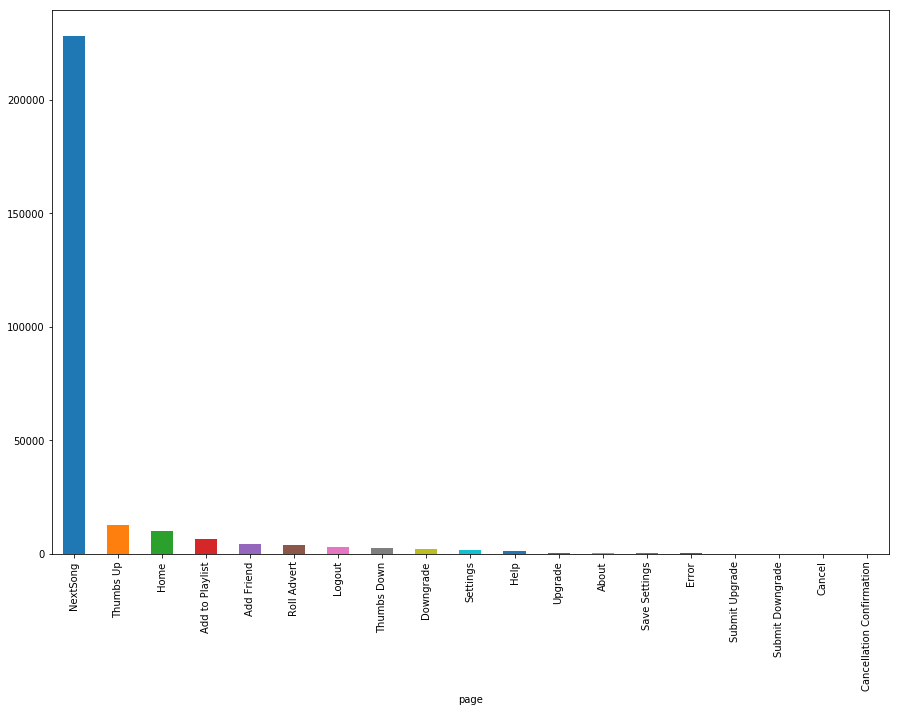

In [30]:
df.set_index("page")['count_'].head(len(df)).plot(kind='bar', figsize=(15,10))

The page "NextSong" dominates the population of pages.

### What are the distributions of the churn vs non-churn users?

In [31]:
df = sparkSession.sql("SELECT churn, count(DISTINCT userId) AS count_ FROM event_data \
                        GROUP BY churn \
                        ORDER BY count(*) DESC").toPandas()
df.head(5)

,churn,count_
0,1,171
1,0,54


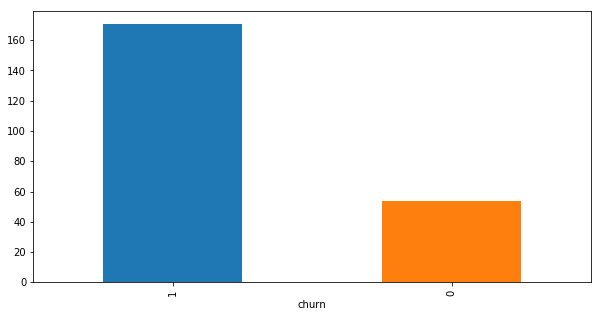

In [32]:
df.set_index("churn")['count_'].head(len(df)).plot(kind='bar', figsize=(10,5))

Most users did not cancel their subscriptions. Seems the retention rate of Sparkify is kind of good.

### What are the distributions of the gender of unique users?

In [33]:
df = sparkSession.sql("SELECT gender, count(DISTINCT userId) AS count_ FROM event_data \
                        GROUP BY gender \
                        ORDER BY count(*) DESC").toPandas()
df.head(5)

,gender,count_
0,F,104
1,M,121


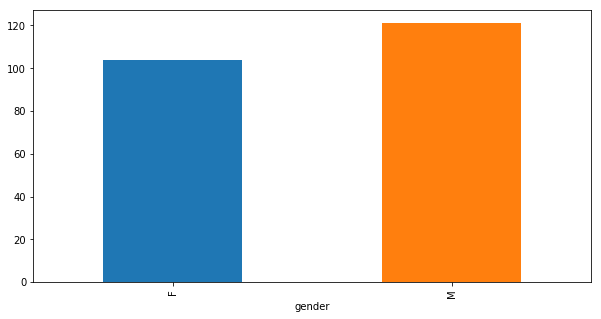

In [34]:
df.set_index("gender")['count_'].head(len(df)).plot(kind='bar', figsize=(10,5))

Male and Female users are about 50/50, male users are slightly more.

### Check if the important columns contain null values

In [35]:
# Define a reusable function to data cleaning
def print_null_value_counts(df, col):
 
    '''
    INPUT:
    df : PySpark dataframe containing data from mini_sparkify_event_data.json
    col : Column name in string from PySpark dataframe (df)
    
    OUTPUT:
    No values returned.
    
    Description:
    This method only prints out how many rows contains null values in the given column name (col), 
    these rows will not be removed.
    '''
    
    count = df.filter(df[col].isNull()).count()
    print("The column {} contains {} rows of null values.".format(col, count))

In [36]:
print_null_value_counts(event_data, "artist")
print_null_value_counts(event_data, "song")
print_null_value_counts(event_data, "length")

The column artist contains 50046 rows of null values.
The column song contains 50046 rows of null values.
The column length contains 50046 rows of null values.


Seems there is a pattern in null values of "artist", "song" and "length". Let's check the "page" column of them.

### Unique pages when either "artist", "song" and "length" contains null values.

In [37]:
df = sparkSession.sql("SELECT DISTINCT page FROM event_data \
                       WHERE (artist IS NULL)  \
                              OR (song IS NULL)  \
                              OR (length IS NULL)").toPandas()
df.head(len(df))

,page
0,Cancel
1,Submit Downgrade
2,Thumbs Down
3,Home
4,Downgrade
5,Roll Advert
6,Logout
7,Save Settings
8,Cancellation Confirmation
9,About


### Unique pages when either "artist", "song" and "length" contains values.

In [38]:
df = sparkSession.sql("SELECT DISTINCT page FROM event_data \
                       WHERE (artist IS NOT NULL)  \
                              AND (song IS NOT NULL)  \
                              AND (length IS NOT NULL)").toPandas()
df.head(len(df))

,page
0,NextSong


Oh got it. Column "artist", "song" and "length" contain values only if the page is "NextSong"

### Summary of "length"

In [39]:
event_data.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Define membershipDays

In [40]:
def get_datediff_udf(x, y):
    
    '''
    INPUT:
    x : Column name of the start date in date format.
    y : Column name of the end date in date format.
    
    OUTPUT:
    The number of days between start date(x) and end date(y).
    
    Description:
    This method is user-defined function to calcuate the number of days between two given dates(x & y).
    '''
    
    date_diff = datetime.datetime.fromtimestamp(x / 1000.0) - datetime.datetime.fromtimestamp(y / 1000.0)
    return int(date_diff.days)

get_datediff = udf(get_datediff_udf, IntegerType())

In [41]:
event_data = event_data.withColumn("daysSinceSignup", get_datediff("ts","registration"))

In [42]:
event_data.select(["ts","registration", "daysSinceSignup"]).orderBy("ts").show(5, False)

+-------------+-------------+---------------+
|ts           |registration |daysSinceSignup|
+-------------+-------------+---------------+
|1538352117000|1538173362000|2              |
|1538352180000|1538331630000|0              |
|1538352394000|1538173362000|2              |
|1538352416000|1538331630000|0              |
|1538352676000|1538173362000|2              |
+-------------+-------------+---------------+
only showing top 5 rows



In [43]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)



In [44]:
# Replace the existing view for spark SQL querying
event_data.createOrReplaceTempView("event_data")

### Define hasPaid

It creates a new column `hasPaid` to define if a user has once paid or not.

In [45]:
# Append a temporary column "paid_indicator" and a mandatory column "hasPaid"
sql = "select *, MAX(paid_indicator) OVER (PARTITION BY userId) AS hasPaid \
FROM ( \
    SELECT \
        *,   \
        CASE WHEN  \
            level = 'paid' THEN 1 \
            ELSE 0 \
        END AS paid_indicator \
    from event_data \
) t"

event_data = sparkSession.sql(sql)

In [46]:
# Drop the temporary column "churn_indicator"
event_data = event_data.drop("paid_indicator")
event_data

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, churn: int, daysSinceSignup: int, hasPaid: int]

In [47]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)
 |-- hasPaid: integer (nullable = true)



In [48]:
# Replace the existing view for spark SQL querying
event_data.createOrReplaceTempView("event_data")

In [49]:
# Test the data
sparkSession.sql("SELECT DISTINCT userId, hasPaid from event_data ORDER BY userId LIMIT 10").show(10)

+------+-------+
|userId|hasPaid|
+------+-------+
|    10|      1|
|   100|      1|
|100001|      0|
|100002|      1|
|100003|      0|
|100004|      1|
|100005|      0|
|100006|      0|
|100007|      1|
|100008|      1|
+------+-------+



## Define a "User Profile" table

In [50]:
sql = " \
SELECT \
    userId, \
    MAX(churn) AS churn,\
    MAX(hasPaid) as hasPaid, \
    COUNT(DISTINCT sessionId) AS numOfSessions, \
    COUNT(DISTINCT artist) / COUNT(DISTINCT sessionId) AS avgArtistsPlayedPerSess, \
    COUNT(DISTINCT song) / COUNT(DISTINCT sessionId) AS avgSongsPlayedPerSess, \
    SUM(length) / COUNT(DISTINCT sessionId) AS avgLengthPlayedPerSess , \
    MAX(daysSinceSignup) AS daysSinceSignup \
FROM event_data \
GROUP BY userId "

df_user_profile = sparkSession.sql(sql)
df_user_profile.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- hasPaid: integer (nullable = true)
 |-- numOfSessions: long (nullable = false)
 |-- avgArtistsPlayedPerSess: double (nullable = true)
 |-- avgSongsPlayedPerSess: double (nullable = true)
 |-- avgLengthPlayedPerSess: double (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)



In [51]:
# Test the data
df_user_profile.show(5, False)

+------+-----+-------+-------------+-----------------------+---------------------+----------------------+---------------+
|userId|churn|hasPaid|numOfSessions|avgArtistsPlayedPerSess|avgSongsPlayedPerSess|avgLengthPlayedPerSess|daysSinceSignup|
+------+-----+-------+-------------+-----------------------+---------------------+----------------------+---------------+
|100010|0    |0      |7            |36.0                   |38.42857142857143    |9562.98533571429      |55             |
|200002|1    |1      |6            |56.5                   |63.0                 |15668.145989999988    |70             |
|125   |1    |0      |1            |8.0                    |8.0                  |2089.1131000000005    |71             |
|124   |1    |1      |29           |76.96551724137932      |115.13793103448276   |34907.31354448276     |131            |
|51    |1    |1      |10           |138.5                  |185.4                |52327.58428000004     |19             |
+------+-----+-------+--

## Some EDAs on the "User Profile"

In [52]:
# Add view for spark SQL querying
df_user_profile.createOrReplaceTempView("df_user_profile")

### Distributions of churn users

In [53]:
df = sparkSession.sql("SELECT churn, COUNT(*) as numOfUsers \
                      FROM df_user_profile GROUP BY churn").toPandas()
df.head(5)

,churn,numOfUsers
0,1,171
1,0,54


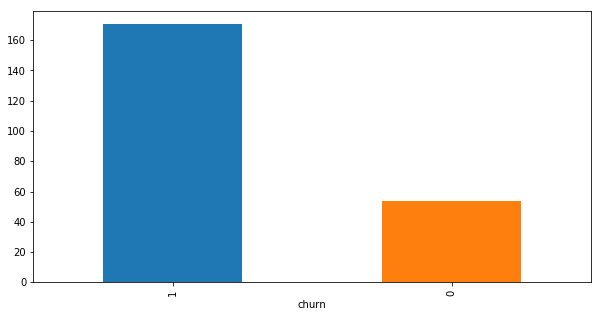

In [54]:
df.set_index("churn")['numOfUsers'].head(len(df)).plot(kind='bar', figsize=(10,5))

This result matches the result we found in earlier. Most users did not cancel their subscriptions. Seems the retention rate of Sparkify is not that good.

### Distributions of paid and unpaid users

In [55]:
df = sparkSession.sql("SELECT hasPaid, COUNT(*) as numOfUsers \
                      FROM df_user_profile GROUP BY hasPaid").toPandas()
df.head()

,hasPaid,numOfUsers
0,1,165
1,0,60


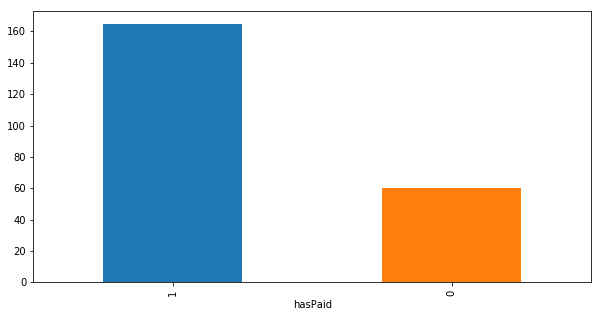

In [56]:
df.set_index("hasPaid")['numOfUsers'].head(len(df)).plot(kind='bar', figsize=(10,5))

Most users are paid users.

### Relationship between paid/unpaid and churn/nonchurn users

In [57]:
df = sparkSession.sql("SELECT churn, hasPaid, COUNT(*) as numOfUsers \
                      FROM df_user_profile GROUP BY hasPaid, churn").toPandas()
df.head()

,churn,hasPaid,numOfUsers
0,0,1,10
1,1,1,155
2,0,0,44
3,1,0,16


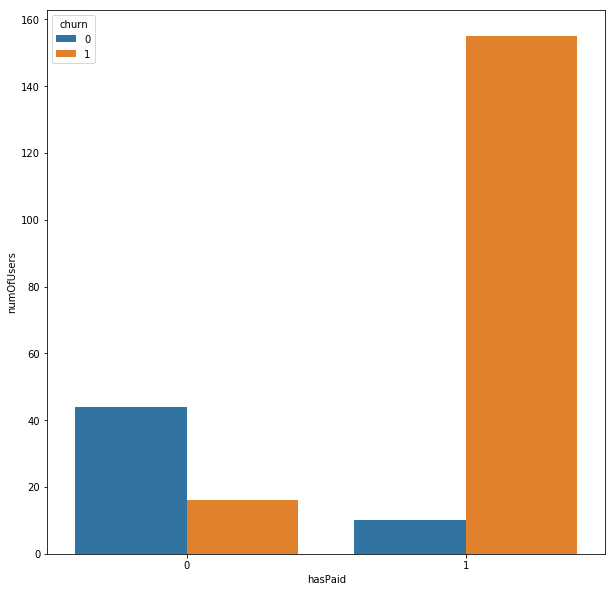

In [58]:
plt.subplots(figsize=[10,10])
sns.barplot(
    x='hasPaid',
    hue='churn', 
    y = 'numOfUsers',
    data=df)

As the diagram show, the retention rate of free-tier users (with 0 in hasPaid) is higher than subscription users (with 1 in hasPaid).

## Create a Vector

In [59]:
X_cols = [
    "hasPaid", 
    "numOfSessions", 
    "avgArtistsPlayedPerSess", 
    "avgSongsPlayedPerSess", 
    "avgLengthPlayedPerSess", 
    "daysSinceSignup"
]
assembler = VectorAssembler(inputCols=X_cols, outputCol="NumFeatures")
df_user_profile = assembler.transform(df_user_profile)
df_user_profile.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- hasPaid: integer (nullable = true)
 |-- numOfSessions: long (nullable = false)
 |-- avgArtistsPlayedPerSess: double (nullable = true)
 |-- avgSongsPlayedPerSess: double (nullable = true)
 |-- avgLengthPlayedPerSess: double (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)
 |-- NumFeatures: vector (nullable = true)



In [60]:
df = df_user_profile.select(X_cols + ["NumFeatures"] ).toPandas()
df.head(5)

,hasPaid,numOfSessions,avgArtistsPlayedPerSess,avgSongsPlayedPerSess,avgLengthPlayedPerSess,daysSinceSignup,NumFeatures
0,0,7,36.000000,38.428571,9562.985336,55,"[0.0, 7.0, 36.0, 38.4285714286, 9562.98533571,..."
1,1,6,56.500000,63.000000,15668.145990,70,"[1.0, 6.0, 56.5, 63.0, 15668.14599, 70.0]"
2,0,1,8.000000,8.000000,2089.113100,71,"[0.0, 1.0, 8.0, 8.0, 2089.1131, 71.0]"
3,1,29,76.965517,115.137931,34907.313544,131,"[1.0, 29.0, 76.9655172414, 115.137931034, 3490..."
4,1,10,138.500000,185.400000,52327.584280,19,"[1.0, 10.0, 138.5, 185.4, 52327.58428, 19.0]"


In [62]:
scaler = Normalizer(inputCol = "NumFeatures", outputCol = "ScaledNumFeatures")
df_user_profile = scaler.transform(df_user_profile)
df_user_profile.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- hasPaid: integer (nullable = true)
 |-- numOfSessions: long (nullable = false)
 |-- avgArtistsPlayedPerSess: double (nullable = true)
 |-- avgSongsPlayedPerSess: double (nullable = true)
 |-- avgLengthPlayedPerSess: double (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)
 |-- NumFeatures: vector (nullable = true)
 |-- ScaledNumFeatures: vector (nullable = true)



In [63]:
df = df_user_profile.select(["NumFeatures", "ScaledNumFeatures"] ).toPandas()
df.head(5)

,NumFeatures,ScaledNumFeatures
0,"[0.0, 7.0, 36.0, 38.4285714286, 9562.98533571,...","[0.0, 0.000731965594219, 0.00376439448456, 0.0..."
1,"[1.0, 6.0, 56.5, 63.0, 15668.14599, 70.0]","[6.38221880626e-05, 0.000382933128376, 0.00360..."
2,"[0.0, 1.0, 8.0, 8.0, 2089.1131, 71.0]","[0.0, 0.000478388763461, 0.00382711010769, 0.0..."
3,"[1.0, 29.0, 76.9655172414, 115.137931034, 3490...","[2.86468548048e-05, 0.000830758789339, 0.00220..."
4,"[1.0, 10.0, 138.5, 185.4, 52327.58428, 19.0]","[1.9110191119e-05, 0.00019110191119, 0.0026467..."


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Split the dataset

Let's split the full dataset into train, test, and validation sets with ratios: 70% train, 15% val, 15% test.

In [64]:
df_train, df_val, df_test = df_user_profile.randomSplit([0.70, 0.15, 0.15], seed=42)

print("Training set shape: ", df_train.count(), len(df_train.columns) )
print("Validation set shape: ", df_val.count(), len(df_val.columns) )
print("Testing set shape: ", df_test.count(), len(df_test.columns) )

Training set shape:  163 10
Validation set shape:  37 10
Testing set shape:  25 10


## Training the model with training set

### Create LogisticRegression model and train it with training set

In [65]:
# Define a reusable function to display the model performance
def show_model_result(df_result):
    
    '''
    INPUT:
    df_result - A PySpark dataframe containing User Profile trained dataset and prediction column.
    
    OUTPUT:
    No output value.
    
    Description:
    It prints out the following metrics based on the trained result:
    1. Four values in confusion matrix
    2. Overall accuracy
    3. Precision
    4. Recall
    5. F1 score
    '''
    
    # Add view for spark SQL querying
    df_result.createOrReplaceTempView("df_result")

    df = sparkSession.sql("SELECT churn, prediction, count(*) AS count_ FROM df_result \
                          GROUP BY churn, prediction").toPandas()

    
    get_count = lambda temp_df: temp_df.count_.values[0] if len(temp_df)>0 else 0
    
    tp = get_count(df.query("churn==1 and prediction==1"))
    tn = get_count(df.query("churn==0 and prediction==0"))
    fp = get_count(df.query("churn==0 and prediction==1"))
    fn = get_count(df.query("churn==1 and prediction==0"))
    
    print ("tp:", tp)
    print ("tn:", tn)
    print ("fp:", fp)
    print ("fn:", fn)
    
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    
    print("Overall accuracy = ", (tp+tn)/(tp+tn+fp+fn))
    print("Precision = ", precision)
    print("Recall = ", recall)
    print("F1 score = ", 2* ((precision*recall)/ (precision+recall)))
    

In [66]:
# Create logistic regression model
regression = LogisticRegression(maxIter=10, regParam=0.0, \
                                featuresCol="ScaledNumFeatures", \
                                labelCol = "churn")

# Train the model with training set
trained_model = regression.fit(df_train)

In [67]:
# Get the prediction from training set
df_result = trained_model.evaluate(df_train).predictions
df_result.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- hasPaid: integer (nullable = true)
 |-- numOfSessions: long (nullable = false)
 |-- avgArtistsPlayedPerSess: double (nullable = true)
 |-- avgSongsPlayedPerSess: double (nullable = true)
 |-- avgLengthPlayedPerSess: double (nullable = true)
 |-- daysSinceSignup: integer (nullable = true)
 |-- NumFeatures: vector (nullable = true)
 |-- ScaledNumFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [68]:
# Result of prediction in training set
show_model_result(df_result)

tp: 125
tn: 0
fp: 38
fn: 0
Overall accuracy =  0.766871165644
Precision =  0.766871165644
Recall =  1.0
F1 score =  0.868055555556


## Validate the model with validation set

In [69]:
# Predict y variable of validation set
df_predicted_val = trained_model.transform(df_val)
show_model_result(df_predicted_val)

tp: 27
tn: 0
fp: 10
fn: 0
Overall accuracy =  0.72972972973
Precision =  0.72972972973
Recall =  1.0
F1 score =  0.84375


### Let's try to tune the model parameter(s) and validate it again

In [70]:
regression = LogisticRegression(maxIter=100, regParam=0.0, \
                                featuresCol="ScaledNumFeatures", \
                                labelCol = "churn")
trained_model = regression.fit(df_train)

In [71]:
# Predict y variable of validation set
df_predicted_val = trained_model.transform(df_val)
show_model_result(df_predicted_val)

tp: 27
tn: 7
fp: 3
fn: 0
Overall accuracy =  0.918918918919
Precision =  0.9
Recall =  1.0
F1 score =  0.947368421053


The F1 score shows the model is kind of good. Let's apply it to testing set.

## Evaulate the model with testing set

In [72]:
# Predict y variable of testing set
df_predicted_test = trained_model.transform(df_test)
show_model_result(df_predicted_test)

tp: 18
tn: 5
fp: 1
fn: 1
Overall accuracy =  0.92
Precision =  0.947368421053
Recall =  0.947368421053
F1 score =  0.947368421053


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.